# Switching Recurrent Neural Networks (SRNNs) Tutorial on Analysis of Lorenz Attractor

### This is the notebook of result analysis (model_#.pt), for running the SRNNs, please refer to demo_lorenz.py and demo_lorenz.ipynb. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from SRNN import model_srnn
from SRNN import inference_network
from SRNN import initialization
from SRNN import train
from SRNN import generative_check
from sklearn.metrics import mean_squared_error

np.random.seed(131)
torch.manual_seed(131)

### Step 1: Load your trained model and Get your test data ready

In [2]:
m1=torch.load('./result/model_0.pt')

C:\Users\yongx\AppData\Local\Temp\ipykernel_51016\923605650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m1=torch.load('./result/model_0.pt')


In [3]:
### Change this to your test data or use the one you specify as 'test' when you run SRNNs
# y_c=np.load('./data/lorenz_new.npy') # (#samples*#time points*#features)
# jobid=0 # set first trial to be validation, the rest of trials to be training.
# test_data=y_c[int(jobid):int(jobid)+1]
test_data=m1['y_test']
#########################################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
y_test=torch.tensor(test_data,dtype=dtype,device=device)
X_test=torch.tensor(0*test_data,dtype=dtype,device=device)

### Step 2: Get your model ready

In [4]:
input_shape=X_test.shape[2] # Input shape of SRNNs, but the models are input free.
num_tv=m1['num_tv'] # Number of RNNs in SRNNs.
hidden_shape=m1['hidden_shape'] # Number of hidden states of SRNNs.


In [5]:
model = model_srnn.Model(input_shape,num_tv,hidden_shape).to(device)
rnninfer=inference_network.RNNInfer(input_shape,hidden_shape).to(device)

In [6]:
model.load_state_dict(m1['model_state_dict'])
rnninfer.load_state_dict(m1['rnninfer_state_dict'])

<All keys matched successfully>

In [7]:
y_pred_test,pos_test,sampled_h_test=train.eval_(model,rnninfer,X_test,y_test,device)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


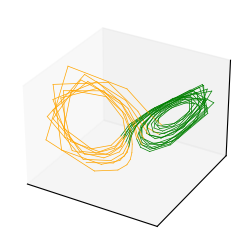

In [8]:
# Let's visualize.
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_pred_test[0])-2):
    ax.plot(y_pred_test[0,i:i+2,0],y_pred_test[0,i:i+2,1],y_pred_test[0,i:i+2,2], lw=0.5,color=color_list[int(np.argmax(pos_test[0],axis=1)[i])])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.savefig('../../OneDrive - Yale University/Figure_NIPS/cosyne_lorenz.eps',bbox_inches='tight', format='eps',dpi=256)
plt.show()

Now, check validation loss and MSE of training.

In [9]:
mse_all_test_ini=m1['mse_all_test_ini']
mse_all_test=m1['mse_all_test']
loss_all_ini=m1['loss_train_ini']
loss_all_train=m1['loss_train']
ini_epochs=len(loss_all_ini)
epochs=len(loss_all_train)

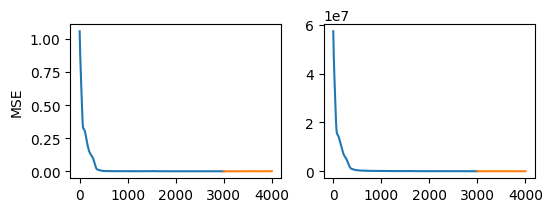

In [10]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],mse_all_test_ini)
plt.plot(plot_epoch[ini_epochs:],mse_all_test)
plt.ylabel('MSE')
plt.subplot(1,2,2)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],loss_all_ini)
plt.plot(plot_epoch[ini_epochs:],loss_all_train)
plt.show()

In [11]:
generative_y_test,generative_h=generative_check.run(model,rnninfer,X_test,y_test,pos_test,device)

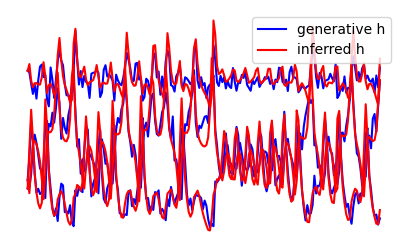

In [12]:
plt.figure(figsize=(5,3))
lines=plt.plot(generative_h,color='blue',label='generative h')
plt.setp(lines[1:],label='_')
lines=plt.plot(sampled_h_test[0],color='red',label='inferred h')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

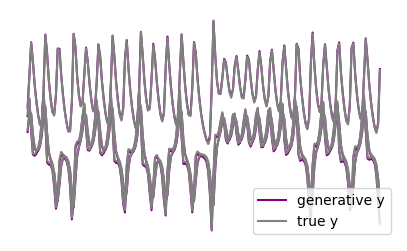

In [13]:
plt.figure(figsize=(5,3))
lines=plt.plot(y_pred_test[0],color='purple',label='generative y')
plt.setp(lines[1:],label='_')
lines=plt.plot(y_test.cpu().detach().numpy()[0],color='gray',label='true y')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

Now, let's look at how states identified by SRNNs change across epochs.

In [14]:
pos_test_all_ini=m1['pos_test_all_ini']
pos_test_all=m1['pos_test_all']

In [15]:
state_all_ini=[]
for i in range(ini_epochs):
    state_all_ini.append(np.argmax(pos_test_all_ini[i,0,:,:],axis=1))
state_all_ini=np.array(state_all_ini)

state_all=[]
for i in range(epochs):
    state_all.append(np.argmax(pos_test_all[i,0,:,:],axis=1))
state_all=np.array(state_all)

state_entire=np.vstack((state_all_ini,state_all))

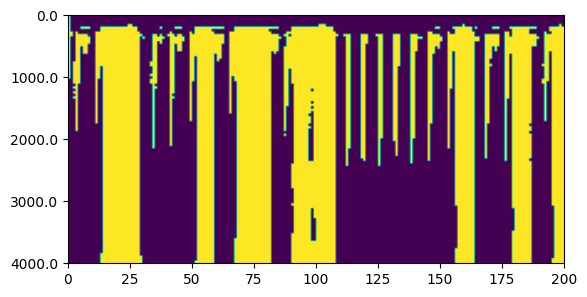

In [16]:
fig, ax = plt.subplots(1,1)
l=int(state_entire.shape[0]/100)
state_show=state_entire[0:1]
for i in range(100):
    state_show=np.vstack((state_show,state_entire[i*l+l:i*l+l+1]))
ax.imshow(state_show,extent=[0,state_show.shape[1],state_entire.shape[0]/l,0])
y_label_list = list(np.linspace(0,state_entire.shape[0],5))
ax.set_yticks(list(np.linspace(0,state_show.shape[0],5)))
ax.set_yticklabels(y_label_list)
plt.show()